In [1]:
# -*- coding: utf-8 -*-
# https://www.youtube.com/watch?v=Y_hzMnRXjhI
# https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/data
import io
import numpy
import matplotlib.pyplot as plt
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
with open("news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

print(sentences[:5])
print(labels[:5])

['thirtysomething scientists unveil doomsday clock of hair loss', 'dem rep. totally nails why congress is falling short on gender, racial equality', 'eat your veggies: 9 deliciously different recipes', 'inclement weather prevents liar from getting to work', "mother comes pretty close to using word 'streaming' correctly"]
[1, 0, 0, 1, 1]


In [4]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_labels = numpy.asarray(training_labels, dtype=numpy.int32)
testing_labels = numpy.asarray(testing_labels, dtype=numpy.int32)

In [5]:
tokenizer = Tokenizer(num_words=vocab_size,
                      oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

In [6]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,
                                maxlen=max_length,
                                padding=padding_type,
                                truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,
                               maxlen=max_length,
                               padding=padding_type,
                               truncating=trunc_type)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 5
history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels),
                    verbose=1)

Train on 20000 samples, validate on 8619 samples
Epoch 1/5
20000/20000 [==============================] - 3s 145us/sample - loss: 0.6609 - accuracy: 0.6194 - val_loss: 0.5543 - val_accuracy: 0.8096
Epoch 2/5
20000/20000 [==============================] - 2s 95us/sample - loss: 0.4272 - accuracy: 0.8316 - val_loss: 0.3789 - val_accuracy: 0.8364
Epoch 3/5
20000/20000 [==============================] - 2s 91us/sample - loss: 0.3171 - accuracy: 0.8745 - val_loss: 0.3417 - val_accuracy: 0.8544
Epoch 4/5
20000/20000 [==============================] - 2s 89us/sample - loss: 0.2664 - accuracy: 0.8953 - val_loss: 0.3307 - val_accuracy: 0.8590
Epoch 5/5
20000/20000 [==============================] - 2s 92us/sample - loss: 0.2317 - accuracy: 0.9123 - val_loss: 0.3317 - val_accuracy: 0.8569


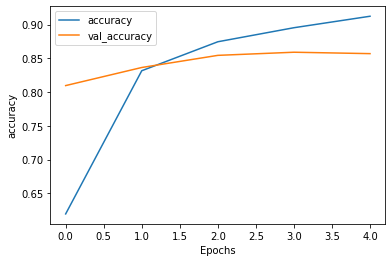

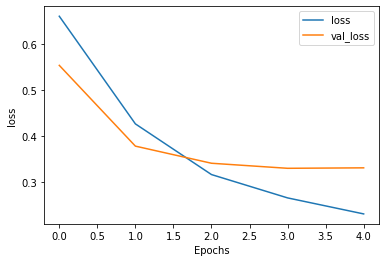

In [9]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [10]:
reverse_word_index = dict([(value, key)
                           for (key, value) in word_index.items()])

In [11]:
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [12]:
print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

<OOV> scientists unveil doomsday clock of hair loss ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
eat your veggies: 9 deliciously different recipes
0


In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [15]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences,
                       maxlen=max_length,
                       padding=padding_type,
                       truncating=trunc_type)
print(model.predict(padded))

[[0.42824864]
 [0.25798434]]
